In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pythonlib.tools.stroketools import strokesInterpolate2, strokesFilter, smoothStrokes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.optimize import minimize_scalar, minimize

plt.style.use('dark_background')

### On off calculation notebook
Same as the panchodate/diegodate nbs but this one is a bit cleaner and clearer for posterity sake

In [ ]:
#Data loaded here is the dat object that is returned from the process_data_singletrial function in the handtrack class
# with open("/home/danhan/freiwaldDrive/dhanuska/230126_pancho_proc_data.pkl", 'rb') as f:
#     pancho1_dfs = pickle.load(f)
# with open("/home/danhan/freiwaldDrive/dhanuska/240605_pancho_proc_data.pkl", 'rb') as f:
#     pancho2_dfs = pickle.load(f)
with open("/home/danhan/freiwaldDrive/dhanuska/hand_track/Pancho/220606_priminvar1/lag_data/ht_proc_data.pkl",'rb') as f:
    pancho3_dfs = pickle.load(f)
with open("/home/danhan/freiwaldDrive/dhanuska/hand_track/Pancho/",'rb') as f:
    pancho3_dfs = pickle.load(f)


In [394]:
print(pancho1_dfs[10]['220914_f12_dlc'])

{'strokes_cam': [array([[ 1.32026247e-02, -5.20423942e-02, -5.78073487e-03,
         3.03816028e+00],
       [ 1.32845853e-02, -5.17691729e-02, -5.74084598e-03,
         3.05938676e+00],
       [ 1.33023122e-02, -5.12814897e-02, -5.64177672e-03,
         3.08061324e+00],
       [ 1.35628457e-02, -4.93994795e-02, -4.66777837e-03,
         3.10183972e+00],
       [ 1.22978164e-02, -4.26833871e-02, -1.57945998e-03,
         3.12306620e+00],
       [ 1.19802996e-02, -3.63476732e-02,  1.27334976e-03,
         3.14429268e+00],
       [ 1.21576445e-02, -2.98512386e-02,  2.79229524e-03,
         3.16551916e+00],
       [ 1.39994713e-02, -2.49868959e-02,  3.41548649e-03,
         3.18674564e+00],
       [ 1.68794364e-02, -1.73756214e-02,  4.17303504e-03,
         3.20797213e+00],
       [ 1.98450925e-02, -1.21998384e-02,  4.53397625e-03,
         3.22919861e+00],
       [ 2.34486656e-02, -4.03468619e-03,  5.17246853e-03,
         3.25042509e+00]]), array([[ 1.61664223e-02,  1.70380461e-02, -2.8

In [385]:
with open("/home/danhan/freiwaldDrive/dhanuska/231211_diego_proc_data.pkl", 'rb') as f:
    diego1_dfs = pickle.load(f)
with open("/home/danhan/freiwaldDrive/dhanuska/240605_diego_proc_data.pkl", 'rb') as f:
    diego2_dfs = pickle.load(f)

#### Five point stencil for velocity and acceleration calculation
This is an accepted method in math to calculate the velocity and acceleration for discrete data at a given point by using the surrounding points.

In [4]:
def fps(x, fs):
    '''Five point stentil function for discrete derivative, scales to m/s auto'''
    v = [(-x[i+2] + 8*x[i+1] - 8*x[i-1] + x[i-2])/12 for i in range(len(x)) if 2<=i<len(x)-2]
    return np.array(v) * fs
def fps2(x, fs):
    '''Same as above but for second derivative scales to m/s**2 auto'''
    a = [(-x[i+2] + 16*x[i+1] - 30*x[i] + 16*x[i-1] - x[i-2])/12 for i in range(len(x)) if 2<=i<len(x)-2]
    return np.array(a) * fs**2

#### Heuristic based approach
Works decently, left it here in case it become useful later. Works by using a few observed patterns in the trajectory structure. Pretty accurate but does not handle edge cases super well.

In [ ]:
def max_dist_heuristic(x, mode):
    '''
    x, n,2 array with a value and a time
    target, target value to get close in this case a mean
    mode, onsets or offsets
    '''
    diffs = np.diff(np.diff(x[:,0]))

    if mode == 'on':
        #Return pt who has biggest difference from previous
        return x[np.argmin(diffs)+1]
    elif mode == 'off':
        #Return pt who has biggest diff from next pt
        return x[np.argmin(diffs)]
    else:
        assert False, 'give mode on or off'
    
def on_off_heuristics(stroke_vs, stroke_as, wind, t, mode, window_size = 0.0008):

    if mode == 'on':
        vz_lb = np.mean(stroke_vs) - window_size
        az_ub = np.mean(stroke_as) + window_size
        az_lb = np.mean(stroke_as) - window_size
        above_lb = wind[:,0] >= vz_lb
        a_in_thresh = (wind[:,1] >= az_lb) & (wind[:,1] <= az_ub)
        above_lb_and_no_next_below = []

        #Make sure all following vs are in thresh
        next_val_true = True
        for val in reversed(above_lb):
            if not val:
                next_val_true = False
            above_lb_and_no_next_below.append(next_val_true)
        above_lb_and_no_next_below.reverse()

        #Maker sure all following as are in thresh
        next_val_true = True
        a_in_thresh_no_next_out = []
        for val in reversed(a_in_thresh):
            if not val:
                next_val_true = False
            a_in_thresh_no_next_out.append(next_val_true)
        a_in_thresh_no_next_out.reverse()

        prev_point_more_neg = wind[:,0] > np.roll(wind[:,0],1)
        both = above_lb_and_no_next_below & prev_point_more_neg & a_in_thresh_no_next_out
        both[0] = False
        filtered = wind[both]
        if len(filtered) == 0:
            return [-100,0,t]
        else:
            pt = filtered[filtered[:,2].argsort()][0]
            return pt
    elif mode == 'off':
        vz_ub = np.mean(stroke_vs) + window_size-0.0002
        under_ub = wind[:,0] <= vz_ub
        below_ub_and_no_prev_below = []
        prev_val_true = True
        for val in under_ub:
            if not val:
                prev_val_true = False
            below_ub_and_no_prev_below.append(prev_val_true)
        next_point_more_pos = wind[:,0] < np.roll(wind[:,0],-1)
        both = below_ub_and_no_prev_below & next_point_more_pos
        both[0] = False
        filtered = wind[both]
        if len(filtered) == 0:
            return [-100,0,t]
        else:
            pt = filtered[filtered[:,2].argsort()][-1]
            return pt
    else:
        assert False, 'give mode on or off'

#### Optimize intersection method
This method seems to work the best to find the onset/offset points. it is going to take in a data structure, dat and then at each touchscreen determined onset/offset point it will fit two lines. One line follows the trajectory of the velocity into/out of the stroke, and the other fits horizontally to the velocity in the stroke. The poiint where these lines intersect is what is taken as the onset/offset. The intuition here is that we are essentially optimizing the elbow of a fitted polynomial/log function but two lines gave a more precise point rather than trying to threshold a continuous function

In [420]:
def calcOnsetOffset(dat, trial_ml2, search_window=0.015, do_ts_average=True, data_use = 'trans', ploton = True):
    """Loops though strok data and calculates onset anbd offset points by optimizing intersection point of positive sloped and horizontal line, fitting
    the data near a stroke. 

    Args:
        dat (df or soemthing): DF holding the data needed for the computation here. Mainly we need all the fields returned from the HT.process data function
        (touch/cam positions and interpolated versions also)
        
        search_window: Numb er in seconds to tell algorithm how far to look before/after stroke to find min/max point (fitted line goes from min/max point to intercept)
        do_ts_average (bool): Average the caluclated point with the touchscreen point (helps reduce variance from less than ideal fits)
        data_use (str): Which data to use ('raw', 'trans'). Raw is raw z coord, trans is z corod after regression with transformation marix
    Returns:
        on_off_pts (dict): Dictionary containing onset and offset pts for {on_fix(offset only), strokes 1...n, off_fix(onset only)}
    """
    assert len(dat) > 0, "No data here"
    if data_use == 'trans':
        cam_pts = dat['trans_pts_time_cam_all']
        strokes_touch = dat["strokes_touch"]
    elif data_use == 'raw':
        cam_pts = dat['pts_time_cam_all']
        strokes_touch = dat["strokes_touch"]
    else:
        assert False, "Not sure what data you want to use"

    cushion = 0.1
    t_onfix_off = strokes_touch[0][-1,2]
    t_offfix_on = strokes_touch[-1][-1,2]
    on_offs = {}
    on_offs['on_fix'] = [None,t_onfix_off]
    for i,strok in enumerate(strokes_touch[1:-1]):
        on_offs[f'stroke_{i}'] = []
        on_offs[f'stroke_{i}'].append(strok[0,2])
        on_offs[f'stroke_{i}'].append(strok[-1,2])
    on_offs['off_fix'] = [t_offfix_on,None]

    # filter data to be within desired times
    pts_cam = cam_pts[(cam_pts[:,3] >= t_onfix_off-cushion) & (cam_pts[:,3] <= t_offfix_on+cushion)]
    cam_fs = 1/np.mean(np.diff(pts_cam[:,3]))
    assert 49.5 <= cam_fs <= 50.5, f'cam fs of {cam_fs}hz is weird'

    #Interpolate to 1000hz
    kind='linear'
    pts_cam_int = strokesInterpolate2([pts_cam],kind=kind,N=["fsnew",1000,cam_fs])[0]

    #Get z data and v data (raw and interp)
    raw_z = pts_cam[:,2]
    int_zt = np.column_stack((pts_cam_int[:,2],pts_cam_int[:,3]))
    raw_vt = np.column_stack((fps(raw_z,cam_fs),pts_cam[2:-2,3]))
    int_vt = np.column_stack((fps(pts_cam_int[:,2],1000),pts_cam_int[2:-2,3]))
    #Smooth interp data
    if_zt = smoothStrokes([int_zt], 1000, window_type='median')[0]
    if_vt = smoothStrokes([int_vt], 1000, window_type='median')[0]

    #onset offset prediction
    search_bound = 0.1 #How far to look before touch onset for min
    stroke_bound = 0.25 #How far to fit into stroke
    int_bound = 0.1 #How far to look before touch onset
    def onset(on):
        #Establish search bounds
        search_bounds = (on-search_bound,on)
        #Get pts in bounds
        cam_pts_to_search = if_vt[(if_vt[:,1] >= search_bounds[0]) & (if_vt[:,1] <= search_bounds[1])]
        #Get min pt in search
        fit_z_min = np.min(cam_pts_to_search[:,0])
        #Get t of min pt
        t_at_zmin = cam_pts_to_search[np.argmin(cam_pts_to_search[:,0]),1]
        #Estblish bounds and extract pts for fitting lines
        intersect_bounds = (t_at_zmin,on)
        fit_bounds = (t_at_zmin,on+stroke_bound)
        cam_pts_to_fit = if_vt[(if_vt[:,1] >= fit_bounds[0]) & (if_vt[:,1] <= fit_bounds[1])]

        def onset_twoline(params):
            xf,yf = params
            #Avoid 0 divide error
            if xf == t_at_zmin:
                return 10000
            m = (yf-fit_z_min) / (xf - t_at_zmin)
            errors = []
            for pt in cam_pts_to_fit:
                x = pt[1] #t
                y = pt[0] #v
                if x <= xf: #fit in v line
                    y_pred = m*(x-t_at_zmin)+fit_z_min
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
                else: #fit in h line
                    y_pred = yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
            return np.sqrt(np.mean(errors))
        fit = minimize(onset_twoline,bounds=[intersect_bounds,[None,None]],x0=[on,0])
        x_elb, y_elb = fit.x
        x_elb_avg = np.mean((x_elb,on))
        slope = (y_elb-fit_z_min)/(x_elb-t_at_zmin)
        z_plot = [slope*(fit_bounds[0]-x_elb)+y_elb,slope*(fit_bounds[1]-x_elb)+y_elb]
        return {
            'slope': slope,
            'elbow_pt': (x_elb,y_elb,x_elb_avg),
            'fit_bounds': fit_bounds,
            'z_plot': z_plot
        }

    search_bound = 0.1 #How far to look before touch offset for min
    stroke_bound = 0.25 #How far to fit into stroke
    int_bound = 0.1 #How far to look before touch offset  
    def offset(off):
        #Establish search bounds
        search_bounds = (off,off+search_bound)
        #Get pts in bounds
        cam_pts_to_search = if_vt[(if_vt[:,1] >= search_bounds[0]) & (if_vt[:,1] <= search_bounds[1])]
        #Get min pt in search
        fit_z_max = np.max(cam_pts_to_search[:,0])
        #Get t of min pt
        t_at_zmax = cam_pts_to_search[np.argmax(cam_pts_to_search[:,0]),1]
        #Estblish bounds and extract pts for fitting lines
        intersect_bounds = (off-int_bound, off)
        fit_bounds = (off-stroke_bound,t_at_zmax)
        cam_pts_to_fit = if_vt[(if_vt[:,1] >= fit_bounds[0]) & (if_vt[:,1] <= fit_bounds[1])]
        def offset_twoline(params):
            xf,yf = params
            #Avoid 0 divide error
            if xf == t_at_zmax:
                return 10000
            m = (fit_z_max-yf) / (t_at_zmax-xf)
            errors = []
            for pt in cam_pts_to_fit:
                x = pt[1] #t
                y = pt[0] #z
                if x >= xf: #fit in v line
                    y_pred = m*(x-xf) + yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
                else: #fit in h line
                    y_pred = yf
                    if y_pred < y:
                        errors.append(((y-y_pred)**2))
                    elif y_pred > y:
                        errors.append(((y-y_pred)**2))
            return np.sqrt(np.mean(errors))
        
        fit = minimize(offset_twoline,bounds=[intersect_bounds,[None,None]],x0=[off,0])
        x_elb, y_elb = fit.x
        x_elb_avg = np.mean((x_elb,off))
        slope = (fit_z_max-y_elb)/(t_at_zmax-x_elb)
        z_plot = [slope*(fit_bounds[0]-x_elb)+y_elb,slope*(fit_bounds[1]-x_elb)+y_elb]
        return {
            'slope':slope,
            'elbow_pt':(x_elb,y_elb,x_elb_avg),
            'fit_bounds':fit_bounds,
            'z_plot': z_plot
        }
    calc_onoffs = {}
    for stroke,onoff in on_offs.items():
        if stroke == 'on_fix':
            calc_onoffs[stroke] = {
                'onset': None,
                'offset': offset(onoff[1])
            }
        elif stroke == 'off_fix':
            calc_onoffs[stroke] = {
                'onset': onset(onoff[0]),
                'offset': None
            }
        else:
            calc_onoffs[stroke] = {
                'onset': onset(onoff[0]),
                'offset': offset(onoff[1])
            }


    

    if ploton:
        fig = plt.figure(figsize=(100,15))
        plt.plot(if_vt[:,1], if_vt[:,0], label='v_filt')
        plt.plot(if_zt[:,1], if_zt[:,0]*10, label='z_filt')
        plt.plot(cam_pts[:,3],cam_pts[:,2], '.-',color='orange')
        for i,val in enumerate(cam_pts):
            if i&1:
                change = 0.001
            else:
                change = -0.001
            plt.annotate(i,(val[3],val[2]+change))
        ymin,ymax = plt.ylim()
        # xmin,xmax = plt.xlim()
        for stroke,onoff in on_offs.items():
            if stroke == 'on_fix':
                plt.fill_between([plt.xlim()[0],onoff[1]], plt.ylim()[0], plt.ylim()[1], fc='lightgreen',alpha=0.2, zorder=0)
            elif stroke == 'off_fix':
                plt.fill_between([onoff[0],plt.xlim()[1]], plt.ylim()[0], plt.ylim()[1], fc='indianred',alpha=0.2, zorder=0)
            else:
                plt.fill_between(onoff, plt.ylim()[0], plt.ylim()[1], fc='lightgrey',alpha=0.2, zorder=0)
            plt.autoscale(False)
        for stroke, onoff in calc_onoffs.items():
            if onoff['onset'] is not None:
                on_touch = on_offs[stroke][0]
                on = onoff['onset']
                elb = on['elbow_pt']
                x = on['fit_bounds']
                y = on['z_plot']
                plt.plot([x[0],x[1]],y, color='w')
                plt.scatter(elb[0],elb[1], color='w')
                x_range = plt.xlim()[1] - plt.xlim()[0]
                plt.axhline(elb[1],color='w', xmin=(on_touch-0.06-plt.xlim()[0])/x_range, xmax=(on_touch+0.06-plt.xlim()[0])/x_range)
                plt.axvline(elb[2], color = 'w', linestyle='--')
            if onoff['offset'] is not None:
                off_touch = on_offs[stroke][1]
                off = onoff['offset']
                elb = off['elbow_pt']
                x = off['fit_bounds']
                y = off['z_plot']
                plt.plot([x[0],x[1]], y, color='w')
                plt.scatter(elb[0],elb[1], color='w')
                x_range = plt.xlim()[1] - plt.xlim()[0]
                plt.axhline(elb[1],color='w', xmin=(off_touch-0.06-plt.xlim()[0])/x_range, xmax=(off_touch+0.06-plt.xlim()[0])/x_range)
                plt.axvline(elb[2], color = 'w', linestyle='--')
        plt.ylim(ymin,ymax)
        # plt.xlim(xmin,xmax)
        plt.legend()
        plt.title(f"Beh Trial:{trial_ml2} ; Vid Trial{trial_ml2-1}")

        return fig, calc_onoffs
    else:
        return None, calc_onoffs

In [421]:
#trial here is one indexed
import os
calc_pts = {}
sdir = '/home/danhan/Documents/ons-offs_figs/pancho3'
os.makedirs(sdir,exist_ok=True)
for trial,dat in pancho3_dfs.items():
    dat = dat['220412_no_f1bf2']
    if len(dat) > 0:
        fig, calc_pts[trial-1] = calcOnsetOffset(dat,trial,data_use='raw')
        fig.savefig(f'{sdir}/trial-{trial}')
    else:
        print(f"Failed for trial {trial-1}, no data")
    plt.close()
    if trial > 40:
        break
    

Failed for trial 14, no data
Failed for trial 19, no data


In [ ]:
#trial here is 0 indexed
trials = [16,19,20,21,22,26,30,35,45,50,150,155,156,200,374,379,390,394]
times_plot_on = []
times_plot_off = []
pts_to_trial = []
for trial, val in calc_pts.items():
    if trial in trials:
        num_strokes = len([1 for strok in val.keys() if 'stroke' in strok])-1
        for i in range(num_strokes):
                dat = val[f'stroke_{i}']
                times_plot_on.append(dat['onset']['elbow_pt'][2])
                times_plot_off.append(dat['offset']['elbow_pt'][2])
                pts_to_trial.append(trial)

#Unlabelled guys in hand chcked data

times_plot_on.pop(36)
times_plot_on.pop(35)
# times_plot_on.pop(34)
times_plot_on.pop(22)

times_plot_off.pop(36)
times_plot_off.pop(35)
times_plot_off.pop(22)

In [ ]:
#Make plots of on off diffs for each type
with open('/home/danhan/Downloads/on_off_tracking - Pancho.csv', 'r') as f:
    df = pd.read_csv(f)
# print(df['vid on t'])
# print(times_plot_on)
for i in range(len(times_plot_off)):
    if np.abs(times_plot_off[i] - df['vid off t'][i]) > 0.02:
        print(pts_to_trial[i], times_plot_off[i], df['vid off t'][i])
df['most_up_on'] = times_plot_on - df['vid on t']
df['most_up_off'] = times_plot_off - df['vid off t']
plot_list = ['pred on diff', 'most_up_on', 'pred off diff', 'most_up_off', 'touch on diff', 'touch off diff']
df[plot_list].plot(kind='box',showmeans=True, figsize=(20,10))

#### Additional thing, corr analysis
This module will try to find the lag in ts vs cam data by using the a corr analysis

In [6]:
def euclidAlign(cam_pts, touch_pts, ploton=False):
    plot_bound_size = 10

    fig, ax = plt.subplots(1,2,figsize=(30,10))
    large_len = len(cam_pts)
    small_len = len(touch_pts)
    cam_pts_xy = cam_pts[:,[0,1]]
    touch_pts_no_time = touch_pts[:,[0,1]]
    
    min_dist = float('inf')
    best_index = -1
    
    for i in range(large_len - small_len + 1):
        window = cam_pts_xy[i:i + small_len]
        distances = np.linalg.norm(window - touch_pts_no_time, axis=1)
        total_dist = np.sum(distances)

        if total_dist < min_dist:
            min_dist = total_dist
            best_index = i
    
    lag = [touch_pts[0,2],cam_pts[best_index,3]]
    lag_adj = lag[0] - lag[1]

    touch_lag_adj = touch_pts[:,2] - lag_adj

    if plot_bound_size <= best_index < len(cam_pts) - plot_bound_size:
        plot_bounds = (best_index-plot_bound_size,best_index+plot_bound_size)
    elif best_index < plot_bound_size and best_index < len(cam_pts) - plot_bound_size:
        plot_bounds = (0, best_index+plot_bound_size)
    elif best_index >= plot_bound_size and best_index > len(cam_pts) - plot_bound_size:
        plot_bounds = (best_index-plot_bound_size,len(cam_pts)-1)
    else:
        plot_bounds = (0,len(cam_pts)-1)

    best_ts = cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,3]

    if ploton:
        ax[0].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,0], '.-', label = 'cam pts')
        # ax[0].plot(cam_pts[:,3],cam_pts[:,0], label='all cam pts')
        ax[0].plot(touch_lag_adj, touch_pts[:,0], '.-', label='touch lag adj')
        ax[0].plot(touch_pts[:,2], touch_pts[:,0], '.-', color='grey', label='raw touch')
        # ax.set_title('Trial:', trial)

        ax[1].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,1], '.-', label='cam pts')
        # ax[1].plot(cam_pts[:,3], cam_pts[:,1], label='all cam pts')
        ax[1].plot(touch_lag_adj,touch_pts[:,1], '.-', label='touch lag adj')
        ax[1].plot(touch_pts[:,2],touch_pts[:,1], '.-', color='grey', label='raw touch')
        plt.legend()

    return lag,fig

In [ ]:
UB = 0.15

In [71]:
def corrAlign(cam_pts, touch_pts, ploton=False):
    plot_bound_size = 0

    fig, ax = plt.subplots(2,2,figsize=(40,20), sharex=True)
    large_len = len(cam_pts)
    small_len = len(touch_pts)
    
    touch_pts_norm = touch_pts[:,[0,1]] - np.mean(touch_pts[:,[0,1]], axis=0)
    # touch_pts_norm = np.divide(touch_pts[:,[0,1]],np.max(touch_pts[:,[0,1]],axis=0))
    
    max_sim = 0
    best_index = -1
    
    sim_course = []
    false_alarms = []
    found_good_sim = False
    for i in range(large_len - small_len + 1):
        window = cam_pts[i:i + small_len]
        window_norm = window[:,[0,1]] - np.mean(window[:,[0,1]], axis=0)
        # window_norm = np.divide(window[:,[0,1]],np.max(window[:,[0,1]],axis=0))
        sim = np.einsum('ij,ij->', window_norm, touch_pts_norm)

        this_lag = touch_pts[0,2] - cam_pts[i,2]
        if sim > max_sim and np.abs(this_lag) < UB:
            max_sim = sim
            best_index = i
            found_good_sim = True
        elif sim > max_sim and max_sim != 0:
            false_alarms.append(cam_pts[i,2])
        sim_course.append((cam_pts[i,2],sim))
    
    #Only save if good peak found
    sim_course = np.array(sim_course)
    if found_good_sim:
        lag = [touch_pts[0,2],cam_pts[best_index,2]]
        lag_adj = lag[0] - lag[1]
    else:
        return None,None
    
    left_peak = False
    right_peak = False
    for i,s in enumerate(sim_course):
        if s[0] == cam_pts[best_index,2]:
            if i > 5:
                left_peak = np.all(sim_course[i-5:i,1] < max_sim)
            else:
                left_peak = np.all(sim_course[:i,1] < max_sim)
            if len(sim_course) > i+5:
                right_peak = np.all(sim_course[i+1:i+6,1] < max_sim)
            else:
                right_peak = np.all(sim_course[i+1:,1] < max_sim)
    if not (left_peak and right_peak):
        return None,None

    touch_lag_adj = touch_pts[:,2] - lag_adj

    if plot_bound_size <= best_index < len(cam_pts) - plot_bound_size:
        plot_bounds = (best_index-plot_bound_size,best_index+plot_bound_size)
    elif best_index < plot_bound_size and best_index < len(cam_pts) - plot_bound_size:
        plot_bounds = (0, best_index+plot_bound_size)
    elif best_index >= plot_bound_size and best_index > len(cam_pts) - plot_bound_size:
        plot_bounds = (best_index-plot_bound_size,len(cam_pts)-1)
    else:
        plot_bounds = (0,len(cam_pts)-1)

    best_ts = cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,2]

    if ploton:
        ax[0,0].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,0], '.-', label = 'cam pts y')
        # ax[0].plot(cam_pts[:,3],cam_pts[:,0], label='all cam pts')
        ax[0,0].plot(touch_lag_adj, touch_pts[:,0], '.-', label='touch lag adj')
        ax[0,0].plot(touch_pts[:,2], touch_pts[:,0], '.-', color='grey', label='raw touch', alpha=0.5)
        ax[0,0].legend()
        # ax.set_title('Trial:', trial)

        ax[0,1].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,1], '.-', label='cam pts x')
        # ax[1].plot(cam_pts[:,3], cam_pts[:,1], label='all cam pts')
        ax[0,1].plot(touch_lag_adj,touch_pts[:,1], '.-', label='touch lag adj')
        ax[0,1].plot(touch_pts[:,2],touch_pts[:,1], '.-', color='grey', label='raw touch',alpha=0.5)
        ax[0,1].legend()

        ax[1,0].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,0], '.-', color = 'indianred')
        # ax[0].plot(cam_pts[:,3],cam_pts[:,0], label='all cam pts')
        # ax[1,0].plot(touch_lag_adj, touch_pts[:,0], '.-', label='touch lag adj')
        ax[1,0].plot(touch_pts[:,2], touch_pts[:,0], '.-', color='indianred', label='raw touch x', alpha=0.5)
        # ax.set_title('Trial:', trial)

        ax[1,0].plot(best_ts,cam_pts[plot_bounds[0]:plot_bounds[1]+small_len,1], '.-', color = 'lightgreen')
        # ax[1].plot(cam_pts[:,3], cam_pts[:,1], label='all cam pts')
        # ax[1,0].plot(touch_lag_adj,touch_pts[:,1], '.-', label='touch lag adj')
        ax[1,0].plot(touch_pts[:,2],touch_pts[:,1], '.-', color='lightgreen', label='raw touch y',alpha=0.5)
        
        ax[1,0].plot(cam_pts[:,2], cam_pts[:,0], label='x coord')
        ax[1,0].plot(cam_pts[:,2], cam_pts[:,1], label = 'y coord')
        for p in false_alarms:
            ax[1,0].axvline(p, color='w', zorder=0, alpha = 0.1)
        ax[1,0].legend()

        ax[1,1].plot(*zip(*sim_course))
        plt.axvline(cam_pts[best_index,2], color ='w', linestyle='--')

    return lag,fig

In [152]:
def get_lags(dfs_func, monkey, run):
    euclid_lags = {}
    corr_lags = {}
    corr_lags_index = []
    euc_lags_index = []
    index = 0
    import os
    import shutil
    euc_dir = f'/home/danhan/Documents/align_figs/{monkey}{run}/euc'
    corr_dir = f'/home/danhan/Documents/align_figs/{monkey}{run}/corr'
    if os.path.exists(euc_dir):
        shutil.rmtree(euc_dir)
    if os.path.exists(corr_dir):
        shutil.rmtree(corr_dir)
    os.makedirs(euc_dir, exist_ok=True)
    os.makedirs(corr_dir, exist_ok=True)
    for trial, dat in dfs_func.items():
        corr_lags[trial] = []
        euclid_lags[trial] = []
        dat = dat['220914_f12_dlc']
        if len(dat) == 0:
            continue
        cam_pts = dat['pts_time_cam_all']
        trans_cam_pts = dat['trans_pts_time_cam_all']
        strokes_touch = dat['strokes_touch']

        touch_fs = 1/np.mean(np.diff(strokes_touch[0][:,2]))
        cam_fs = 1/np.mean(np.diff(cam_pts[:,3]))
        trans_cam_fs = 1/np.mean(np.diff(trans_cam_pts[:,3]))

        
        t_onfix_off = strokes_touch[0][-1,2]
        t_offfix_on = strokes_touch[-1][0,2]

        # filter data to be within desired times
        all_cam = cam_pts[(cam_pts[:,3] >= t_onfix_off) & (cam_pts[:,3] <= t_offfix_on)]
        trans_all_cam = trans_cam_pts[(trans_cam_pts[:,3] >= t_onfix_off) & (trans_cam_pts[:,3] <= t_offfix_on)]
        
        if len(all_cam) == 0:
            print('Skipping trial:', trial)
            continue

        cam_interp = strokesInterpolate2([all_cam],kind='linear',N=["fsnew",1000,cam_fs])
        cam_interp_smth = smoothStrokes(cam_interp, 1000, window_type='median')[0]
        cam_interp_smth = cam_interp_smth[:,[0,1,3]]

        trans_cam_interp = strokesInterpolate2([trans_all_cam],kind='linear',N=["fsnew",1000,trans_cam_fs])
        trans_cam_interp_smth = smoothStrokes(trans_cam_interp, 1000, window_type='median')[0]
        # trans_cam_interp_smth = trans_cam_interp_smth[:,[0,1,3]]

        touch_interp = strokesInterpolate2(strokes_touch,kind='linear',N=["fsnew",1000,touch_fs])
        touch_interp_noz = []
        for stroke in touch_interp:
            touch_interp_noz.append(stroke[:,[0,1,3]])
        touch_interp_noz = touch_interp_noz[1:-1]

        for touch_stroke in touch_interp_noz:
            touch_stroke_filt = touch_stroke
            if len(touch_stroke_filt) == 0:
                continue
            euc_lag, euc_fig = euclidAlign(trans_cam_interp_smth,touch_stroke_filt, ploton=True)
            corr_lag, corr_fig = corrAlign(cam_interp_smth,touch_stroke_filt, ploton=True)
            corr_lags[trial].append(corr_lag)
            corr_lags_index.append(corr_lag)
            euclid_lags[trial].append(euc_lag)
            euc_lags_index.append(euc_lag)
            if euc_fig is not None:
                euc_fig.savefig(f'/home/danhan/Documents/align_figs/{monkey}{run}/euc/{index}-trial{trial}_euc.png')
            if corr_fig is not None:
                corr_fig.savefig(f'/home/danhan/Documents/align_figs/{monkey}{run}/corr/{index}-trial{trial}_corr.png')
            index = index + 1
            plt.close('all')
    return corr_lag,corr_lags_index,euc_lag,euc_lags_index

def plot_stuff(corr_lags, euc_lags, good_inds):
    plt.rcParams["figure.figsize"] = (10, 5)
    all_corr_lags = []
    for trial,lags in corr_lags.items():
        all_corr_lags.extend([c[0]-c[1] for c in lags if c is not None])
    corr_lag_nums = []
    for index in good_inds:
        trial = int(index.split('-')[0])
        stroke = int(index.split('-')[1])
        this_lag = corr_lags[trial][stroke]
        if this_lag is None:
            continue
        lag_num = this_lag[0]-this_lag[1]
        corr_lag_nums.append(lag_num)
        print(index,lag_num)
    euc_lag_nums = []
    # for index in good_inds:
    #     trial = int(index.split('-')[0])
    #     stroke = int(index.split('-')[1])
    #     this_lag = euc_lags[trial][stroke]
    #     if this_lag is None:
    #         continue
    #     lag_num = this_lag[0]-this_lag[1]
    #     euc_lag_nums.append(lag_num)
    #     # print(index,lag_num)
    bins = 30
    plt.hist(all_corr_lags, bins=bins, color='indianred', alpha=0.5, label='corr lag')
    # plt.hist(all_euc_lags, bins=bins, color='lightgreen', alpha=0.5, label='euc lag')
    plt.show()
    plt.hist(corr_lag_nums, bins=bins, color='indianred', alpha=0.5, label='corr lag')
    # plt.hist(euc_lag_nums, bins=bins, color='lightgreen', alpha=0.5, label='euc lag')
    plt.legend()
    plt.show()

    corr_mean = round(np.mean(corr_lag_nums),4)
    # euc_mean = round(np.mean(euc_lag_nums),4)
    # plt.boxplot([corr_lag_nums,euc_lag_nums], label=[f'corr lag {corr_mean}', f'euc lag {euc_mean}'])
    plt.boxplot(corr_lag_nums, label=f'corr lag {corr_mean}')
    plt.legend()
    plt.show()
    plt.plot(all_corr_lags,'.-')
    plt.show()
    # plt.plot(all_euc_lags,'.-')
        # if trial > 20:
        #     break

In [400]:
with open('/home/danhan/Documents/lag_data.pkl','rb') as f:
    dat = pickle.load(f)
print(dat.keys())

dict_keys(['pancho1', 'pancho2', 'diego1', 'diego2'])


## PANCHO 1

In [138]:
def max_depth(d):
    if isinstance(d, dict):
        return 1 + max((max_depth(value) for value in d.values()), default=0)
    return 0

In [ ]:
print(dat)

11-0 0.02481193566692763
15-0 0.04899383215550879
17-0 0.0128029675129131
18-0 0.019863237670834977
18-1 0.06126977452103333
19-0 0.05697709706103682
19-1 0.056126374670344426
20-1 0.03787049255577468
20-2 0.04253597020207511
21-0 0.01264317662733161
21-1 0.06703781642558049
22-0 0.023755196721523042
22-1 0.0328568802058502
23-0 0.049861545940691254
23-2 0.039531356344190804
24-1 0.025757431486404414
25-1 0.01413336776541918
26-1 0.03872627912089843
27-0 0.005080558900120824
28-0 0.036896592782560855
28-2 0.05414155522989539
29-1 0.03366032686136222
30-0 0.036223920721191405
30-1 0.03722506647793988
31-1 0.05966435197751263
32-2 0.039454699818072037
33-0 0.011058190113023336
33-1 0.07040987796320586
34-1 0.07169258839696901
35-2 0.032199797560430454
35-3 0.0074359580709906226


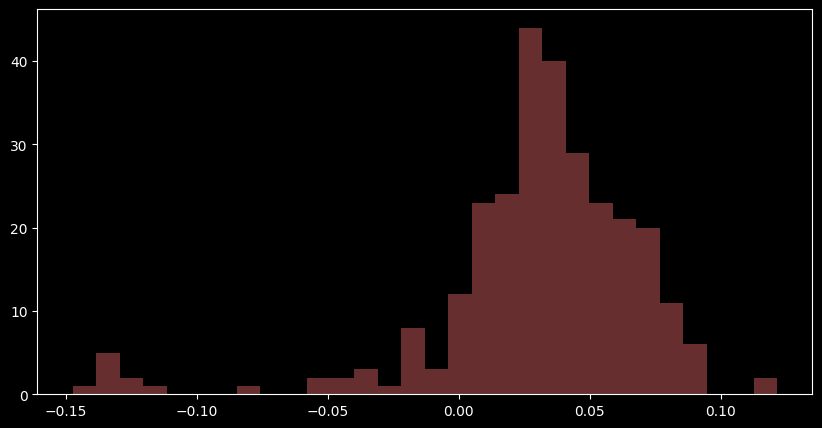

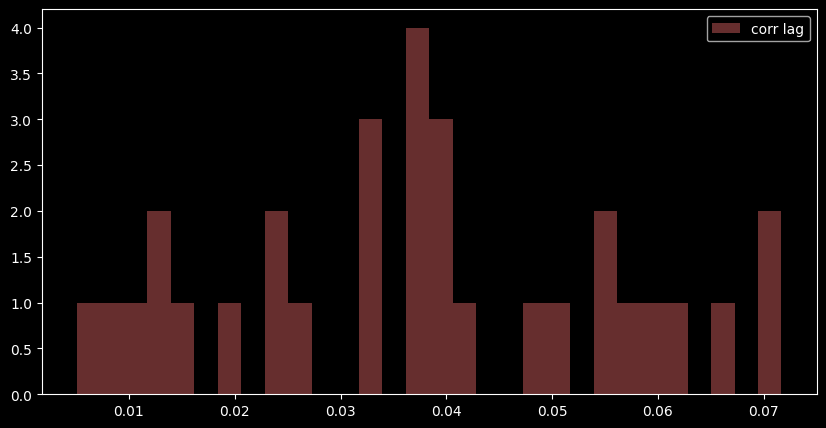

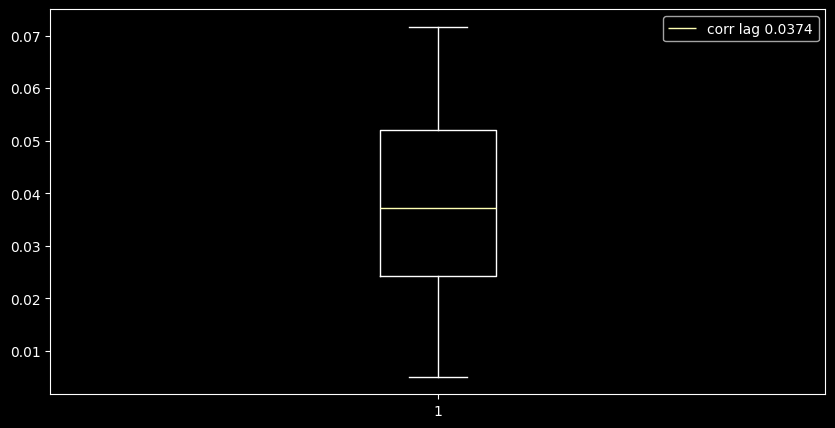

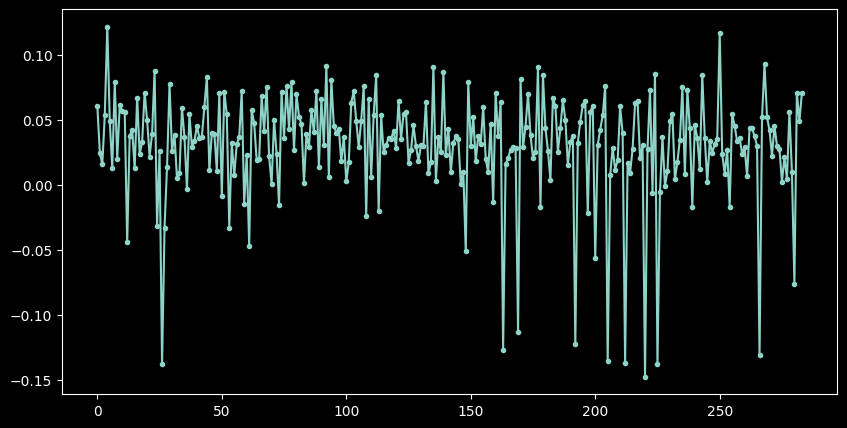

In [401]:
p1 = dat['pancho1']
p1['good_inds'] = ['11-0','15-0','17-0','18-0','18-1','19-0','19-1','20-1','20-2','21-0','21-1','22-0','22-1','23-0','23-2','24-1','25-1','26-1','27-0','28-0','28-2','29-1','30-0','30-1','31-1','32-2','33-0','33-1','34-1','35-2','35-3']
plot_stuff(p1['corr_lags'],p1['euc_lags'],p1['good_inds'])

## PANCHO 2

In [ ]:
p2corr_lag,p2corr_lags_index,p2euc_lag,p2euc_lags_index = get_lags(pancho2_dfs, 'pancho',2)

50-0 0.03609571644073384
52-0 0.0443615705437459
53-0 0.045322535000249964
55-0 0.063404481187467
65-0 0.08279654090345101
66-0 0.04546773474018995
67-0 0.027035639248720322
68-0 0.037015575596816674
84-0 0.030260391331975
86-0 0.01144137436901449
88-0 0.02739650817148931
89-0 0.0623948726339103
90-0 0.0451192058656007
91-0 0.046036775724275
92-0 0.053940233755301215
93-0 0.048378963131260555
95-0 0.014273972602738993
97-0 0.062312788782760364
103-0 0.06802493665578968
106-0 0.05656618548640324
108-0 0.044922096513506204
109-0 0.09071096281767055


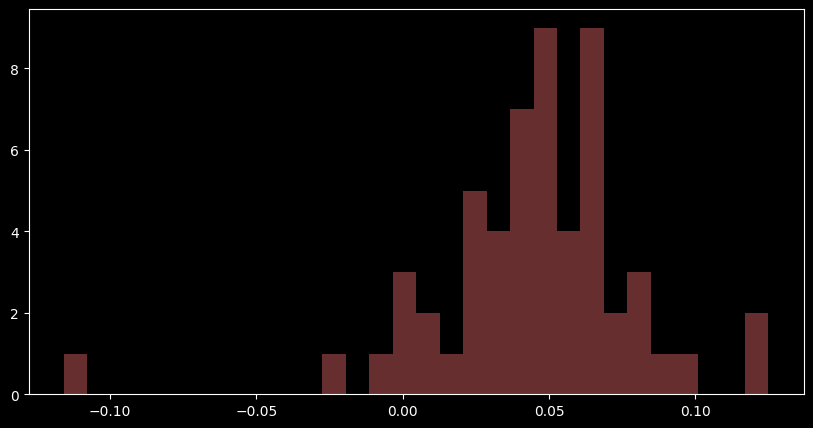

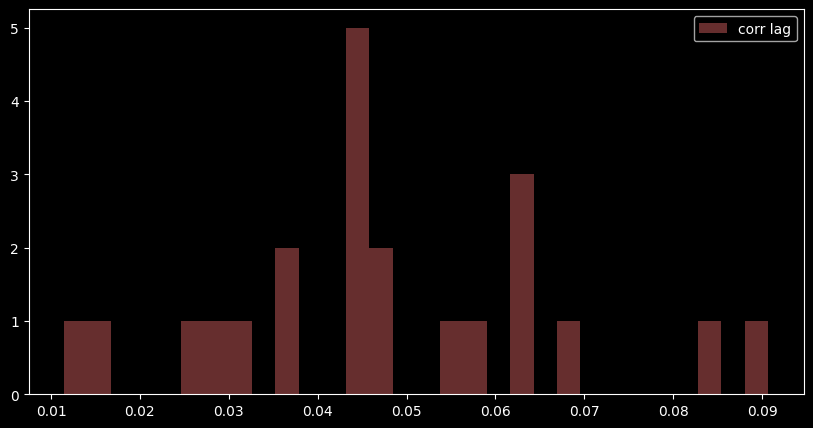

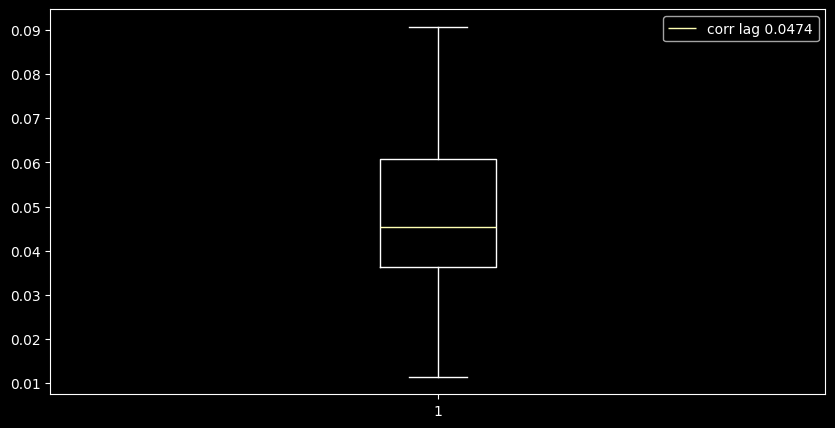

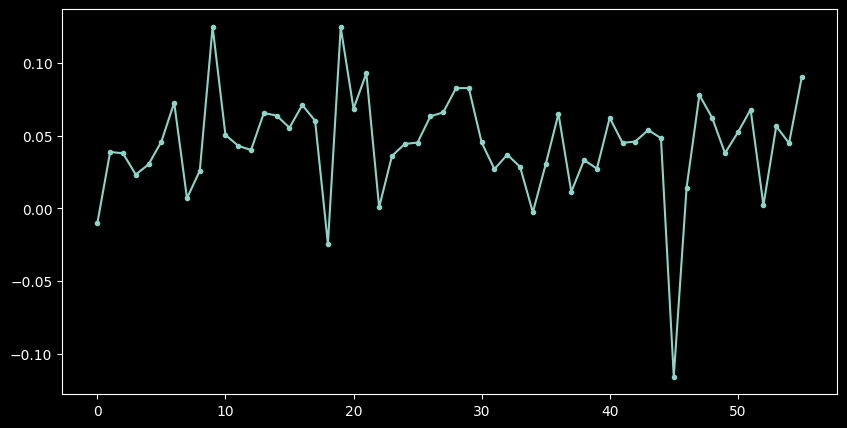

In [402]:
p2 = dat['pancho2']
p2['good_inds'] = ['50-0','52-0','53-0','55-0','65-0','66-0','67-0','68-0','84-0','86-0','88-0','89-0','90-0','91-0','92-0','93-0','95-0','97-0','103-0','106-0','108-0','109-0']
plot_stuff(p2['corr_lags'],p2['euc_lags'],p2['good_inds'])

## DIEGO 1

In [ ]:
d1corr_lag,d1corr_lags_index,d1euc_lag,d1euc_lags_index = get_lags(diego1_dfs, 'diego',1)

10-0 0.042422408065216466
14-0 0.017836440671971765
16-0 0.036975976499495466
17-0 0.03770147723644168
20-0 0.037923427939505316
21-0 0.023298098764494846
22-0 0.04371116770926342
26-0 0.013474667429611564
27-0 0.012951446218557372
28-0 0.02621249078360499
29-0 0.03314040107421601
41-0 0.018978352389237507
42-0 0.046321625405904676
43-0 0.04239853076216704
47-0 0.04336727814783092
48-0 0.039096144925123255
49-0 0.028463200839258906
56-0 0.02831085208327533
58-0 0.008391543360859899
63-0 0.038326954355123455
66-0 0.014059813576975166
70-0 0.045796831168831265
72-0 0.03589748340280963
73-0 0.024447961540628782
76-0 0.03317560805365716
80-0 0.010756884574277592
89-0 0.002285219628017643
92-0 0.027797078133832365
95-0 0.0675544501510954
96-0 0.04657023403263416
99-0 0.03831946258630392
102-0 0.00910347107721865
106-0 0.04553315115777323
107-0 0.017331374643874575


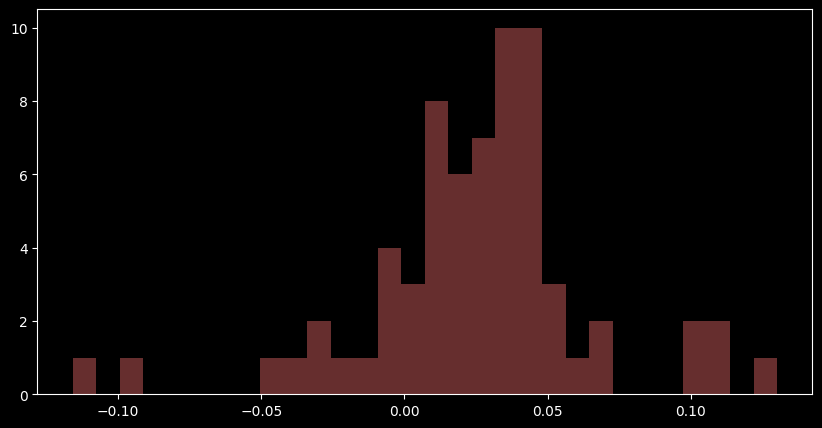

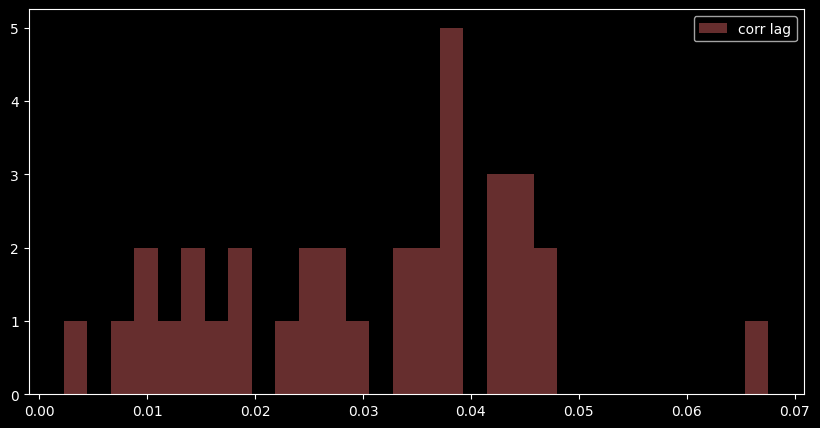

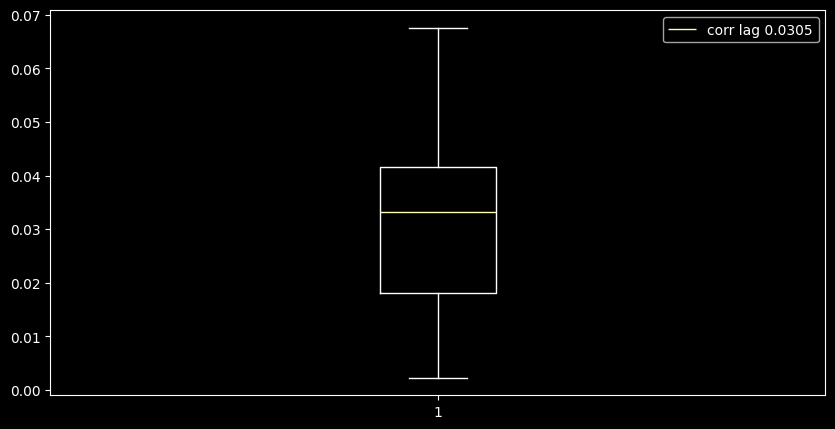

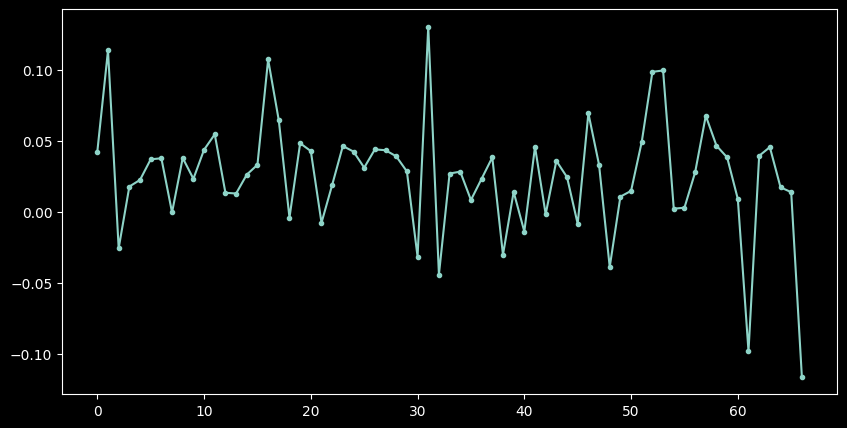

In [403]:
d1 = dat['diego1']
d1['good_inds'] = ['10-0','14-0','16-0','17-0','20-0','21-0','22-0','26-0','27-0','28-0','29-0','41-0','42-0','43-0','47-0','48-0','49-0','56-0','58-0','63-0','66-0','70-0','72-0','73-0','76-0','80-0','89-0','92-0','95-0','96-0','99-0','102-0','106-0','107-0']
plot_stuff(d1['corr_lags'],d1['euc_lags'],d1['good_inds'])

## DIEGO 2

In [ ]:
d2corr_lag,d2corr_lags_index,d2euc_lag,d2euc_lags_index = get_lags(diego2_dfs,'diego',2)

62-0 0.053630597142174
63-0 0.051960705576759025
67-0 0.043677020683585255
71-0 0.04111408321643406
79-0 0.05678125975199144
91-0 0.04784825579572427
93-0 0.01677640494220789
98-0 0.05142594713470672
100-0 0.04296035963881106
102-0 0.05142699135101747
111-1 0.08534050179211405
112-1 0.07822033449007204
113-0 0.03585183741865006
113-1 0.06683995167764234
116-1 0.03145191539365477
116-2 0.07933698042870496
118-0 0.05791265990008121
118-2 0.0592678176703334
119-0 0.05472506003671196
119-1 0.07273603407366735
122-0 0.027090996366522013
123-2 0.07319702383662197
125-2 0.02606908235294103
126-0 0.04527603937354563
129-2 0.037321330454790136
130-1 0.05151371800155413
132-2 0.032715502730409796
133-1 0.07644072539713065
135-1 0.06983449074074155
142-0 0.069357794298198


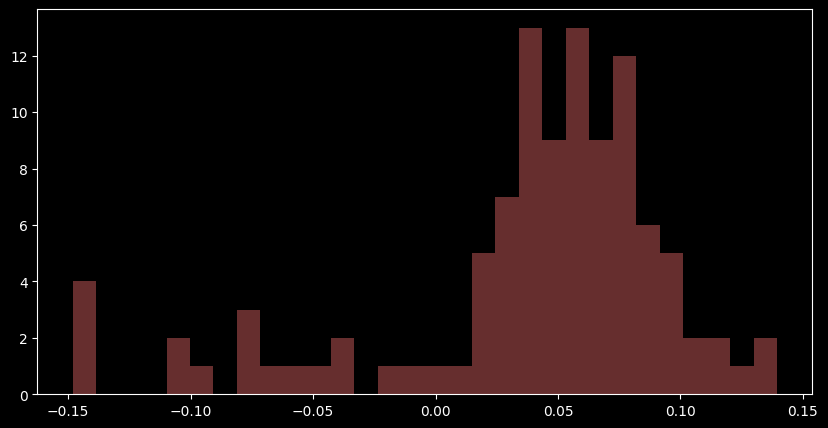

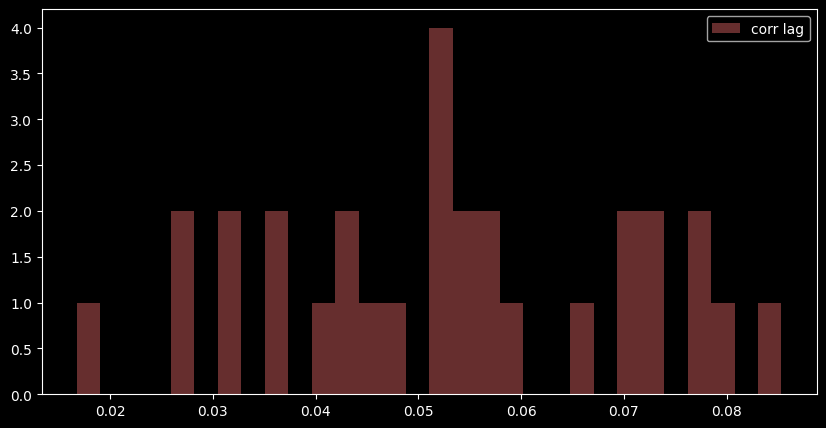

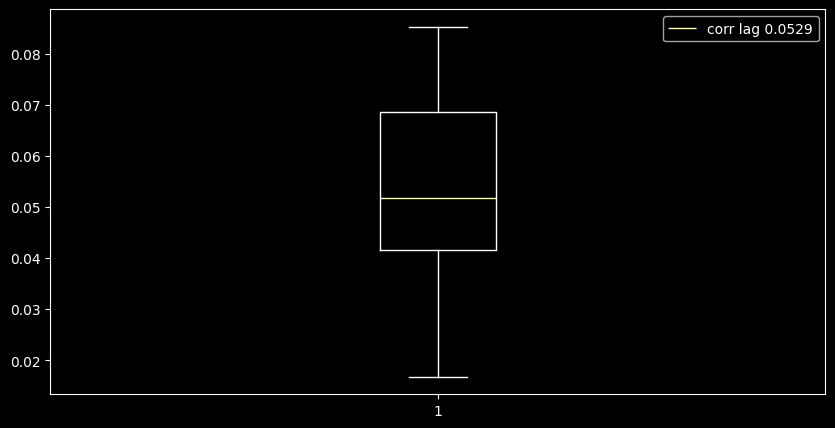

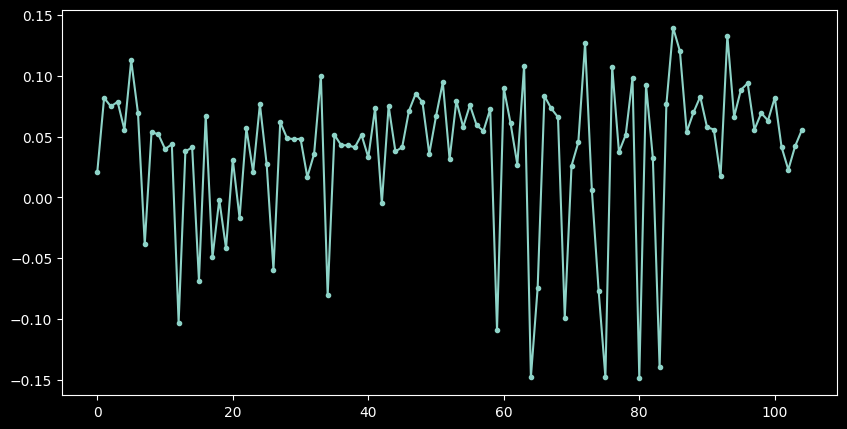

In [404]:
d2 = dat['diego2']
d2['good_inds'] = ['62-0','63-0','67-0','71-0','79-0','89-0','91-0','93-0','98-0','100-0','102-0','111-1','112-1','113-0','113-1','116-1','116-2','118-0','118-2','119-0','119-1','122-0','123-2','125-0','125-2','126-0','129-2','130-1','132-2','133-1','135-1','142-0']
plot_stuff(d2['corr_lags'],d2['euc_lags'],d2['good_inds'])

In [434]:
from pythonlib.tools.stroketools import *
from drawmonkey.tools.preprocess import *
from drawmonkey.tools.handtrack import HandTrack, getTrialsCameraFrametimes


In [450]:
#one indexed trial nums
ind1_vid = 0
ind1_ml2 = 1
sess_print = ''
trange = range(15,25)

animal, date, expt, sess = ('Pancho','220606','priminvar1',1)
fd_p2 = loadSingleDataQuick(animal, date, expt, sess)

animal, date, expt, sess = ('Pancho','240605','primsingridpancho2',1)
fd_p1 = loadSingleDataQuick(animal, date, expt, sess)

# HT = HandTrack(ind1_vid, ind1_ml2, fd, sess_print=sess_print, animal=animal, date=date, expt=expt)
# HT.load_campy_data(ind1_ml2)
# HT.fit_regression(trange)


# #one indexed trial nums
# animal, date, expt, sess = ('Diego','240605','primsingriddiego2c',1)
# fd_d2 = loadSingleDataQuick(animal, date, expt, sess)
# chan = 'Btn1'

/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/220606/220606_*_priminvar1_Pancho_1.pkl
/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/220606/220606_*_priminvar1_Pancho_1.pkl
-- loaded presaved data: /home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/220606/220606_164244_priminvar1_Pancho_1.pkl
/home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/240605/240605_*_primsingridpancho2_Pancho_1.pkl
/home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/240605/240605_*_primsingridpancho2_Pancho_1.pkl
-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/240605/240605_111059_primsingridpancho2_Pancho_1.pkl
HOTKEY updating these trials: [8, 11, 12, 18, 39, 40, 41, 66, 72, 87, 89, 91, 99, 103, 129, 149, 153, 155, 157, 158, 169, 179, 182, 183, 196, 198, 200, 203, 207, 215, 218, 222, 228, 229, 238, 258, 268, 269, 270, 271, 277, 280, 284, 389, 391, 399, 410, 414, 440, 469, 476, 483, 485, 518, 519, 521, 5

In [457]:
fd_p2['params']['sample_rate'] = fd_p2['params']['sample_rate'][0]
stroke_times = getTrialsStrokesByPeanuts(fd_p2,200)
print(stroke_times)


[]


In [345]:
def find_nearest_cam_frame(t,cam_pts):
    diffs = []
    for p in cam_pts:
        diffs.append(np.abs(p-t))
    diffs = np.array(diffs)
    min_ind = np.argmin(diffs)
    return min_ind

In [405]:
beh_codes = {}
for trial,dat in diego2_dfs.items():
    if len(dat) == 0:
        continue
    dat = dat['220914_f12_dlc']
    if len(dat) == 0:
        continue
    stroke_times = getTrialsStrokesByPeanuts(fd_d2,trial)
    ht_strokes = getTrialsStrokes(fd_d2,trial,window_rel_go_reward = [-0.1, 0.1])
    times=getTrialsTimeOfBehCode(fd_d2,trial,16)
    beh_codes[trial] = times
    strokes_cam = dat['strokes_cam']
    strokes_touch = dat['strokes_touch']
    all_cam = dat['pts_time_cam_all']
    for strok_cam, strok_touch,time in zip(strokes_cam,strokes_touch,times):
        print('trial',trial)
        print('pnut',stroke_times[0][0,2],'beh:',time)
        print('touch:',strokes_touch[1][0,2],'t0:',all_cam[0,3])
        print('ht stroke:',ht_strokes[1][0,2])
        print('cam frame stroke', find_nearest_cam_frame(stroke_times[0][0,2],all_cam[:,3]))
        print('')



500.0
500.0
trial 50
pnut 4.614 beh: 1.2817838999908417
touch: 4.614 t0: 0.014
ht stroke: 4.614
cam frame stroke 220

500.0
500.0
trial 51
pnut 4.614 beh: 1.4479143000207841
touch: 4.614 t0: 0.024
ht stroke: 4.614
cam frame stroke 218

500.0
500.0
trial 53
pnut 4.986 beh: 1.7187324999831617
touch: 4.986 t0: 0.026000000000000002
ht stroke: 4.986
cam frame stroke 238

500.0
500.0
trial 54
pnut 4.418 beh: 1.3317144999746233
touch: 4.418 t0: 0.008
ht stroke: 4.418
cam frame stroke 211

500.0
500.0
trial 56
pnut 5.038 beh: 1.5944219999946654
touch: 5.038 t0: 0.018000000000000002
ht stroke: 5.038
cam frame stroke 241

500.0
500.0
trial 57
pnut 4.64 beh: 1.6375665999948978
touch: 4.64 t0: 0.012
ht stroke: 4.64
cam frame stroke 221

500.0
500.0
trial 58
pnut 4.86 beh: 1.3619402999756858
touch: 4.86 t0: 0.018000000000000002
ht stroke: 4.86
cam frame stroke 232

500.0
500.0
trial 59
pnut 5.05 beh: 1.5943871000781655
touch: 5.05 t0: 0.024
ht stroke: 5.05
cam frame stroke 240

500.0
500.0
trial 60

[1.4129332000156865]


In [381]:
for trial,dat in pancho2_dfs.items():
    fig = plt.figure(figsize=(300,10))
    dat_frames = getTrialsAnalogData(fd_p2, trial, chan)
    v = dat_frames[:,0] # voltage
    t = dat_frames[:,1]

    # should already be thresholded, by do this anyway so that no numerical errors.
    
    v[v>=0.5] = 1
    v[v<0.5] = 0
    vdiff = np.diff(v)

    # Get onsets, offsets index
    
    ons = np.where(vdiff==1)[0]+1 # plus 1, sinec want first frame of new state.
    offs = np.where(vdiff==-1)[0]+1
    ons_sec = t[ons]
    offs_sec = t[offs]

    dat = dat['220914_f12_dlc']
    if len(dat) == 0:
        continue
    all_pts = dat['trans_pts_time_cam_all']
    diffs = np.diff(all_pts[:,3])
    inds = [i for i,p in enumerate(diffs)]
    y = [1 for p in all_pts]
    diff_ts = all_pts[1:,3]
    plt.scatter(diff_ts,diffs)
    plt.plot(dat_frames[:,1],(dat_frames[:,0]-0.03)/10,'.-',alpha=0.3)
    ymin,ymax = plt.ylim()
    for d in diff_ts:
        plt.axvline(d)
    for o in ons_sec:
        plt.axvline(o,color='lightgreen',linestyle='--', alpha=0.3)
    for o in offs_sec:
        plt.axvline(o,color='indianred',linestyle='--', alpha=0.3)
    for i,val in enumerate(diffs):
        if val > .0201 or val < 0.019:
            plt.annotate(i,(i,val))
    plt.ylim(ymin,ymax)
    fig.savefig(f'/home/danhan/Desktop/volt_figs/{trial}')
    plt.close()

    if trial > 40:
        break

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

<Figure size 30000x1000 with 0 Axes>

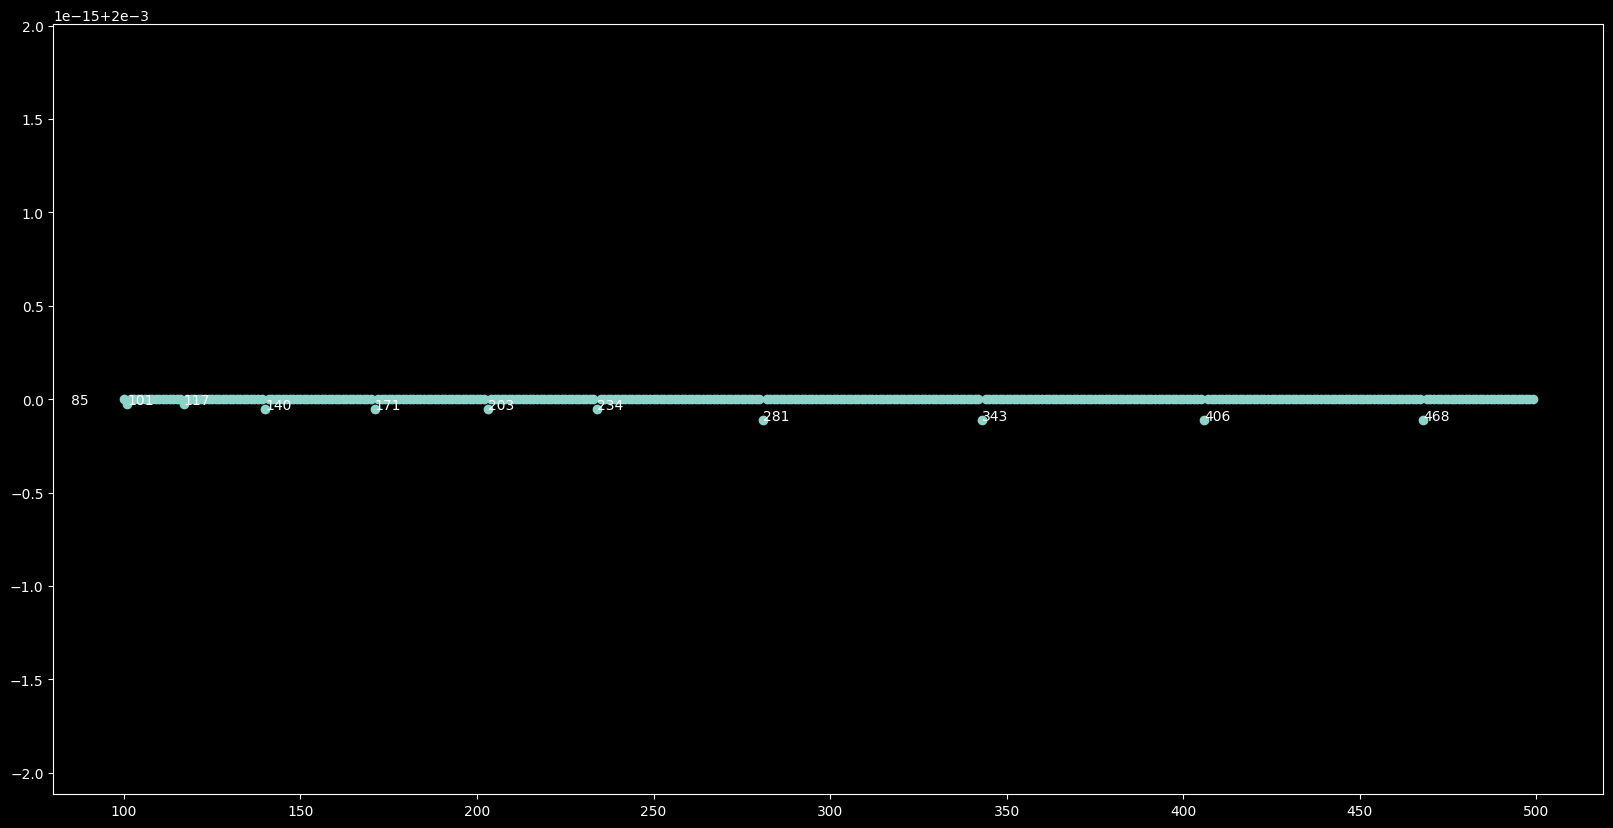

In [376]:
plt.figure(figsize=(20,10))
time_diffs = np.diff(dat_frames[:,1])
inds = [i for i,p in enumerate(time_diffs)]
y = [1 for i,p in enumerate(dat_frames[:,1])]
plt.scatter(inds[100:500],time_diffs[100:500])
for i,val in enumerate(time_diffs):
    if val < np.mean(time_diffs):
        plt.annotate(i,(i,val))

0.043285714285714275


/tmp/ipykernel_29348/1480430896.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(pancho_dates,[0.0465,0.0375,0.0428,0.0414],'.-',color = 'lightgreen',label='Pancho')
/tmp/ipykernel_29348/1480430896.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(diego_dates,[0.0528,0.0305,0.0515],'.-', color='indianred',label='Diego')
/tmp/ipykernel_29348/1480430896.py:6: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dt.datetime(2023,11,16),0.0728,'.', color='green')


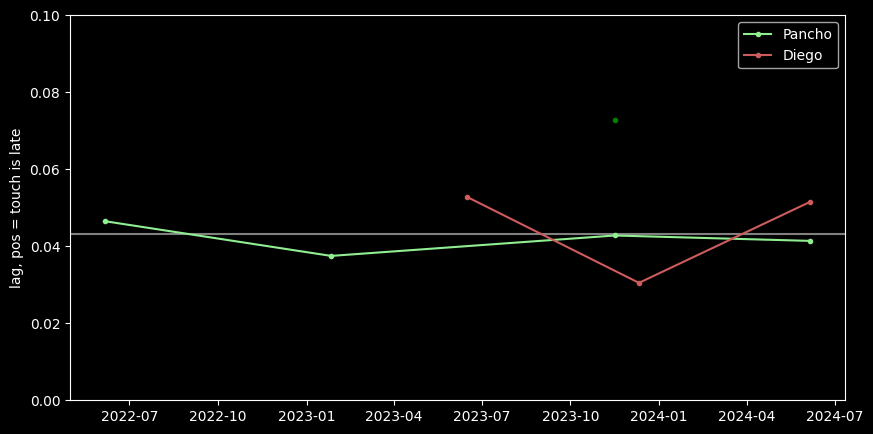

In [474]:
import datetime as dt
pancho_dates = [dt.datetime(2022,6,6),dt.datetime(2023,1,26),dt.datetime(2023,11,16),dt.datetime(2024,6,5)]
diego_dates = [dt.datetime(2023,6,16),dt.datetime(2023,12,11),dt.datetime(2024,6,5)]
plt.plot_date(pancho_dates,[0.0465,0.0375,0.0428,0.0414],'.-',color = 'lightgreen',label='Pancho')
plt.plot_date(diego_dates,[0.0528,0.0305,0.0515],'.-', color='indianred',label='Diego')
plt.plot_date(dt.datetime(2023,11,16),0.0728,'.', color='green')
plt.axhline(np.mean([0.0465,0.0375,0.0428,0.0414,0.0528,0.0305,0.0515]),color='grey',zorder=0)
plt.ylabel('lag, pos = touch is late')
plt.legend()
plt.ylim((0,.1))
print(np.mean([0.0465,0.0375,0.0428,0.0414,0.0528,0.0305,0.0515]))